In [1]:
# Load the required packages

import pandas as pd
import numpy as np 
import re

from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

from urllib.parse import urlparse,urlencode
from bs4 import BeautifulSoup
from datetime import datetime
import ipaddress
import whois
import urllib
import urllib.request
import tldextract

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from urllib.request import urlopen

import timeit

## Phishing Dataset

In [2]:
phishing_raw_df = pd.read_csv("Main_dataset.csv", header = 0)

In [3]:
phishing_raw_df = phishing_raw_df.dropna()
phishing_raw_df = phishing_raw_df.drop_duplicates()
phishing_raw_df = phishing_raw_df.reset_index(drop=True)
phishing_raw_df.shape

(72363, 12)

In [4]:
print(phishing_raw_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72363 entries, 0 to 72362
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   domain          72363 non-null  object
 1   ranking         72363 non-null  int64 
 2   isIp            72363 non-null  int64 
 3   valid           72363 non-null  int64 
 4   activeDuration  72363 non-null  int64 
 5   urlLen          72363 non-null  int64 
 6   is@             72363 non-null  int64 
 7   isredirect      72363 non-null  int64 
 8   haveDash        72363 non-null  int64 
 9   domainLen       72363 non-null  int64 
 10  nosOfSubdomain  72363 non-null  int64 
 11  label           72363 non-null  int64 
dtypes: int64(11), object(1)
memory usage: 6.6+ MB
None


Class Legitimate URL: 31025
Class Phishing URL: 41338
Proportion: 0.75 : 1


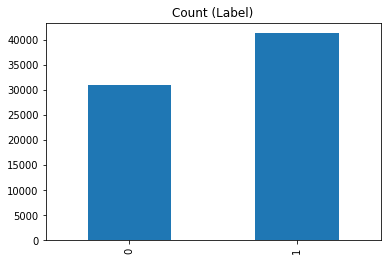

In [5]:
target_count = phishing_raw_df.label.value_counts()
print('Class Legitimate URL:', target_count[0])
print('Class Phishing URL:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

phishing_raw_df.label.value_counts().plot(kind='bar', title='Count (Label)');

Random under-sampling:
0    31025
1    31025
Name: label, dtype: int64


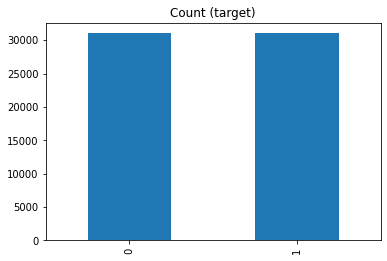

In [6]:
# Class count
count_class_1, count_class_0 = phishing_raw_df.label.value_counts()

# Divide by class
df_class_0 = phishing_raw_df[phishing_raw_df['label'] == 0]
df_class_1 = phishing_raw_df[phishing_raw_df['label'] == 1]

df_class_1_under = df_class_1.sample(count_class_0)
phishing_raw_df = pd.concat([df_class_1_under, df_class_0], axis=0)

print('Random under-sampling:')
print(phishing_raw_df.label.value_counts())

phishing_raw_df.label.value_counts().plot(kind='bar', title='Count (target)');

In [7]:
phishing_raw_df.head()

,domain,ranking,isIp,valid,activeDuration,urlLen,is@,isredirect,haveDash,domainLen,nosOfSubdomain,label
24759,thegrandvacations.com/~dolphin/paypal/,10000000,0,0,0,38,0,0,0,21,1,1
26711,bjcurio.com/js/index.htm?us.battle.net/login/e...,10000000,0,1,5113,100,0,0,0,11,1,1
50121,naturallgroup.com/remake/inst4llation/unit23.php,10000000,0,1,3288,48,0,0,0,17,1,1
16163,paypal.com.cgi-bin.logincmd5645548.syut.tv/Pay...,10000000,0,0,0,72,0,0,1,42,5,1
35099,9d345009-a-62cb3a1a-s-sites.googlegroups.com/s...,4570,0,1,6939,343,0,0,1,44,2,1


## Data Pre-processing

In [8]:
# Across the entire dataset, 0 indicates legitimate url and 1 indicates phishing url
# Legitimate - 0; Phishing - 1

# Function to check rank of the URL
# Returns 0 if the rank is less than 100000 for the given URL else returns 1

def rank(url):
    try:
    #Filling the whitespaces in the URL if any
        url = urllib.parse.quote(url)
        rank = BeautifulSoup(urllib.request.urlopen("http://data.alexa.com/data?cli=10&url=" + url).read(), "xml").find(
            "REACH")['RANK']
        rank = int(rank)
    except TypeError:
        return 1
    if rank <100000:
        return 0
    else:
        return 1

# Function to check if an IP is found in the URL
# Returns 1 if IP is found in the given URL else returns 0

def isIP(url):
    try:
        ipaddress.ip_address(url)
        ip = 1
    except:
        ip = 0
    return ip

# Function to validity of the URL domain
# Returns 1 if age of the domain is less than 6 else returns 0

def isValid(domain_name):
    creation_date = domain_name.creation_date
    expiration_date = domain_name.expiration_date
    if (isinstance(creation_date,str) or isinstance(expiration_date,str)):
        try:
            creation_date = datetime.strptime(creation_date,'%Y-%m-%d')
            expiration_date = datetime.strptime(expiration_date,"%Y-%m-%d")
        except:
              return 1
    if ((expiration_date is None) or (creation_date is None)):
        return 1
    elif ((type(expiration_date) is list) or (type(creation_date) is list)):
        return 1
    else:
        ageofdomain = abs((expiration_date - creation_date).days)
        if ((ageofdomain/30) < 6):
            age = 1
        else:
            age = 0
    return age

# Function to check the expiration of the URL domain
# Returns 1 if the domain has expired else returns 0

def domain_reg_len(domain_name):
    expiration_date = domain_name.expiration_date
    if isinstance(expiration_date,str):
        try:
            expiration_date = datetime.strptime(expiration_date,"%Y-%m-%d")
        except:
            return 1
    if (expiration_date is None):
        return 1
    elif (type(expiration_date) is list):
        return 1
    else:
        today = datetime.now()
        end = abs((expiration_date - today).days)
        if ((end/30) < 6):
            end = 0
        else:
            end = 1
    return end

In [9]:
# Function to check for '@' in the URL
# Returns 1 if found else returns 0

def isat(url):
    if "@" in url:
        return 1    
    else:
        return 0    

# Function to check for '//' in the URL
# Returns 1 if found within length of 7 for the given URL or if 'http' is found else returns 0

def isRedirect(url):
    pos = url.rfind('//')
    if pos > 6:
        if pos > 7:
            return 1
        else:
            return 0
    else:
        return 0

# Function to check for '-' in the URL
# Returns 1 if found else returns 0

def haveDash(url):
    if '-' in urlparse(url).netloc:
        return 1            
    else:
        return 0    
    
# Function to check number of subdomains in the URL
# Returns 0 if number of subdomains is 1 else returns 1

def no_sub_domain(url):
    url = url.replace("www.","")
    url = url.replace("."+tldextract.extract(url).suffix,"")
    count = url.count(".")
    if count==1:
        return 0
    else:
        return 1

# Function to check for 'https' in the URL
# Returns 1 if found else returns 0

def httpDomain(url):
    domain = urlparse(url).netloc
    if 'http' in domain:
        return 1
    else:
        return 0

# Function to checks the length of the URL
# Returns 0 if the length is less than 54 else returns 1

def LongURL(url):
    if len(url) < 54:
        return 0            
    else:
        return 1            

#listing shortening services
shortening_services = r"bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|" \
                      r"yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|" \
                      r"short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|" \
                      r"doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|db\.tt|" \
                      r"qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|q\.gs|is\.gd|" \
                      r"po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|x\.co|" \
                      r"prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|" \
                      r"tr\.im|link\.zip\.net"

# Function to check if the URL belong to shortening services
# Returns 1 if found else returns 0

def tinyURL(url):
    match=re.search(shortening_services,url)
    if match:
        return 1
    else:
        return 0

In [10]:
# Feature engineering

# Insert a new column to the dataframe which shows if 'http' is found in the domain part of the URL.
phishing_raw_df["Domain_http"] = phishing_raw_df["domain"].apply( lambda x: httpDomain(x))

# Insert a new column to the dataframe indicating the length of the URL.
phishing_raw_df["LongURL"] = phishing_raw_df["domain"].apply( lambda x: LongURL(x))

# Insert a new column to the dataframe indicating if the URL belongs to any of the shortening services.
phishing_raw_df["TinyURL"] = phishing_raw_df["domain"].apply( lambda x: tinyURL(x))

# Alter the values in 'nosOfSubdomain' column of the dataframe.
# If the number of sub domains is more than 1, then it is a phishing site.
phishing_raw_df["nosOfSubdomain"] = phishing_raw_df["domain"].apply( lambda x: no_sub_domain(x))

# Alter the values in 'activeDuration' column of the dataframe.
# If the value is greater than 365 (1 year), then it is a legitimate site.
phishing_raw_df["activeDuration"] = phishing_raw_df["activeDuration"].apply( lambda x: 1 if x <= 365 else 0)

# Alter the values in the dataframe column 'ranking'
# If the value is greater than 100000, then it is a phishing site
phishing_raw_df["ranking"] = phishing_raw_df["ranking"].apply( lambda x: 0 if x < 100000 else 1)

# Remove the unwanted columns from the dataframe
phishing_raw_df.drop(['urlLen','domainLen','domain'], inplace=True,axis=1)

# Reorder and rename the columns in the dataframe
Columns = ['Rank','isIP','isValid','Domain_reg_len','is@','isRedirect','haveDash','SubDomain','Label','Domain_http','LongURL','TinyURL']
new_columns = ['Rank','isIP','isValid','Domain_reg_len','is@','isRedirect','haveDash','SubDomain','Domain_http','LongURL','TinyURL','Label']
phishing_raw_df.columns = Columns
phishing_raw_df = phishing_raw_df.reindex(columns=new_columns)

# Shuffle the rows in the dataset so that when splitting the train and test set are equally distributed

phishing_raw_df = phishing_raw_df.sample(frac=1).reset_index(drop=True)

#Display the dataset after feature engineering

phishing_raw_df.head()

,Rank,isIP,isValid,Domain_reg_len,is@,isRedirect,haveDash,SubDomain,Domain_http,LongURL,TinyURL,Label
0,1,0,0,1,0,0,0,1,0,0,0,1
1,1,0,0,1,0,0,1,0,0,1,0,0
2,1,0,1,0,0,0,0,1,0,0,0,0
3,1,0,0,1,0,0,0,1,0,1,0,1
4,1,0,0,1,0,0,0,0,0,0,0,0


In [11]:
phishing_raw_df.isnull().sum()

Rank              0
isIP              0
isValid           0
Domain_reg_len    0
is@               0
isRedirect        0
haveDash          0
SubDomain         0
Domain_http       0
LongURL           0
TinyURL           0
Label             0
dtype: int64

In [12]:
phishing_raw_df.describe()

,Rank,isIP,isValid,Domain_reg_len,is@,isRedirect,haveDash,SubDomain,Domain_http,LongURL,TinyURL,Label
count,62050.000000,62050.000000,62050.000000,62050.000000,62050.000000,62050.000000,62050.000000,62050.000000,62050.0,62050.000000,62050.000000,62050.000000
mean,0.662659,0.000129,0.593215,0.411668,0.002450,0.006575,0.142514,0.549106,0.0,0.354021,0.069621,0.500000
std,0.472806,0.011354,0.491238,0.492140,0.049434,0.080822,0.349579,0.497587,0.0,0.478219,0.254510,0.500004
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.500000
75%,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.0,1.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000


<AxesSubplot:>

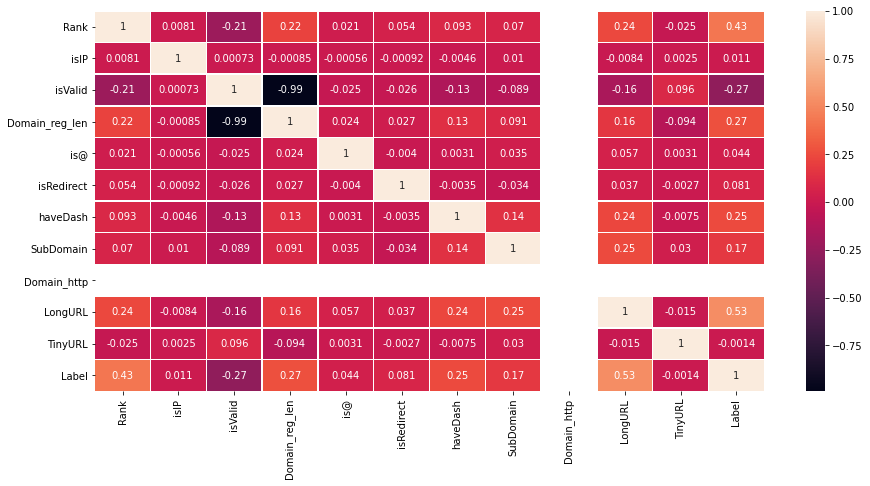

In [13]:
plt.figure(figsize=(15,7))
sns.heatmap(phishing_raw_df.corr(),annot=True, linewidth=0.5)

In [14]:
X=phishing_raw_df.drop(["Label"],axis=1)
Y=phishing_raw_df["Label"]
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=101)
data_classes = ['0','1']

In [15]:
dtc = DecisionTreeClassifier(criterion = "entropy", random_state = 100,max_depth = 5)
dtc = dtc.fit(X_train,y_train)

In [16]:
y_pred_test = dtc.predict(X_test)
y_pred_train = dtc.predict(X_train)

In [17]:
acc_train_dtc = accuracy_score(y_train,y_pred_train)
acc_test_dtc = accuracy_score(y_test,y_pred_test)

print("Decision Tree: Accuracy on training Data: {:.3f}".format(acc_train_dtc))
print("Decision Tree: Accuracy on test Data: {:.3f}".format(acc_test_dtc))

Decision Tree: Accuracy on training Data: 0.821
Decision Tree: Accuracy on test Data: 0.821


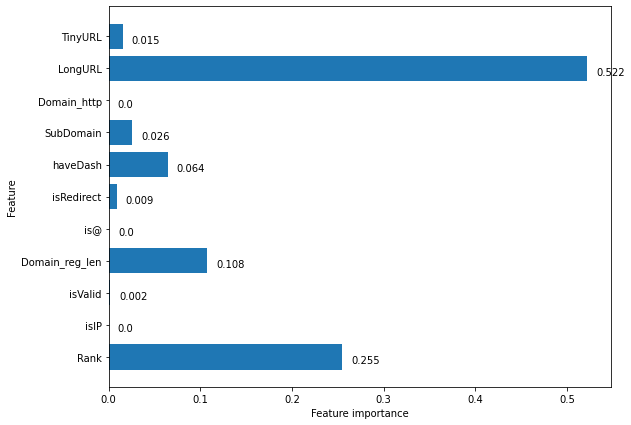

In [18]:

plt.figure(figsize=(9,7))
n_features = X_train.shape[1]
bar1 = plt.barh(range(n_features), dtc.feature_importances_, align='center')
plt.yticks(np.arange(n_features), X_train.columns)
plt.xlabel("Feature importance")
plt.ylabel("Feature")
# plotting Feature importance on the graph itself
idx = 0
for rect in bar1:
    width = rect.get_width()
    plt.text(rect.get_width()+0.01, rect.get_y()+rect.get_height()/4,
                round(dtc.feature_importances_[idx],3), rotation=0)
    idx = idx+1
    
plt.show()

In [19]:
feature_importance=(dict(zip(X.columns, dtc.feature_importances_)))
sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

[('LongURL', 0.5217566786390834),
 ('Rank', 0.25492800863403126),
 ('Domain_reg_len', 0.10769812565000497),
 ('haveDash', 0.0641468147149353),
 ('SubDomain', 0.025802271834105037),
 ('TinyURL', 0.015257888700464002),
 ('isRedirect', 0.008615416942734114),
 ('isValid', 0.0016607833713497815),
 ('is@', 0.00013401151329221064),
 ('isIP', 0.0),
 ('Domain_http', 0.0)]

In [20]:
X = phishing_raw_df.drop(["Domain_http","is@","isIP","Label"],axis=1)
Y = phishing_raw_df["Label"]
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=101)

In [21]:
#function to call for storing the results
#def storeResults(model, a,b):
    #ML_Model.append(model)
    #acc_train.append(round(a, 3))
    #acc_test.append(round(b, 3))
    #return ML_Model, acc_train, acc_test

### XGBoost

In [22]:
def XG_Boost_classifier():
    #calculating start time
    starttime = timeit.default_timer()
    XGB_model = XGBClassifier(random_state=0)
    XGB_model.fit(X_train, y_train)

    pred_XGB_test=XGB_model.predict(X_test)
    pred_XGB_train=XGB_model.predict(X_train)
    # calculating over all time taken
    time = timeit.default_timer() - starttime
    print('\n---------- XGBoost ----------\n')
    print('Classification Report:\n', classification_report(y_test, pred_XGB_test, target_names=['0','1']))
    kappa_XGB = cohen_kappa_score(y_test, pred_XGB_test)
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, pred_XGB_test),display_labels=['0','1'])
    print('\nconfusion matrix:\n',disp.plot())

    plot_precision_recall_curve(XGB_model, X_test, y_test, name = 'XGBoost')
    return (('XGBoost',accuracy_score(y_train,pred_XGB_train),accuracy_score(y_test,pred_XGB_test),kappa_XGB, time))


## Decision Tree

In [23]:
def Decision_Tree_classifier():
    #calculating start time
    starttime = timeit.default_timer()
    dtc = DecisionTreeClassifier(criterion = "entropy", random_state = 100,max_depth = 5)
    dtc = dtc.fit(X_train,y_train)

    pred_dtc_test = dtc.predict(X_test)
    pred_dtc_train = dtc.predict(X_train)
    # calculating over all time taken
    time = timeit.default_timer() - starttime
    print('\n---------- Decision Tree ----------\n')
    print('Classification Report :\n', classification_report(y_test, pred_dtc_test, target_names=['0','1']))
    kappa_dtc = cohen_kappa_score(y_test, pred_dtc_test)
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, pred_dtc_test),display_labels=['0','1'])
    print('\nconfusion matrix:\n',disp.plot())

    plot_precision_recall_curve(dtc, X_test, y_test, name = 'Decision Tree')
    return (('Decision Tree',accuracy_score(y_train,pred_dtc_train),accuracy_score(y_test,pred_dtc_test), kappa_dtc, time))

## Neural Network

In [24]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score


def Neural_Network_classifier():
#training the neural network with 3 layers 
#features_train, features_test, target_train, target_test = train_test_split(X,Y, test_size=0.3, random_state=17)
    #calculating start time
    starttime = timeit.default_timer()
    mlp = MLPClassifier(hidden_layer_sizes=(12,12,12), activation='relu', solver='adam', max_iter=500)
    mlp.fit(X_train,y_train)
    
    pred_NN_test = mlp.predict(X_test)
    pred_NN_train = mlp.predict(X_train)
    # calculating over all time taken
    time = timeit.default_timer() - starttime
    print('\n---------- Neural Network ----------\n')
    print('Classification Report:\n', classification_report(y_test, pred_NN_test, target_names=['0','1']))
    kappa_NN = cohen_kappa_score(y_test, pred_NN_test)
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, pred_NN_test),display_labels=['0','1'])
    print('\nconfusion matrix:\n',disp.plot())
    plot_precision_recall_curve(mlp, X_test, y_test, name = 'Neural Network')
    return (('Neural Network',accuracy_score(y_train,pred_NN_train),accuracy_score(y_test,pred_NN_test), kappa_NN, time))

# SVM

In [25]:
from sklearn.svm import SVC

def Svm_classifier():
    #calculating start time
    starttime = timeit.default_timer()
    svm = SVC(kernel='linear', C=1.0, random_state=12)
    svm.fit(X_train, y_train)
    
    pred_svm_test = svm.predict(X_test)
    pred_svm_train = svm.predict(X_train)
    # calculating over all time taken
    time = timeit.default_timer() - starttime
    print('\n---------- SVM ----------\n')
    print('Classification Report:\n', classification_report(y_test, pred_svm_test, target_names=['0','1']))
    kappa_svm = cohen_kappa_score(y_test, pred_svm_test)
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, pred_svm_test),display_labels=['0','1'])
    print('\nconfusion matrix:\n',disp.plot())
    plot_precision_recall_curve(svm, X_test, y_test, name = 'SVM')
    return (('SVM',accuracy_score(y_train,pred_svm_train),accuracy_score(y_test,pred_svm_test), kappa_svm, time))

# Naive Bayes

In [26]:
from sklearn.naive_bayes import BernoulliNB

def Naive_Bayes_classifier():
#GaussianNB,MultinomialNB
    #calculating start time
    starttime = timeit.default_timer()
    Nb_clf = BernoulliNB()
    Nb_clf.fit(X_train,y_train)
    
    pred_nb_test = Nb_clf.predict(X_test)
    pred_nb_train = Nb_clf.predict(X_train)
    # calculating over all time taken
    time = timeit.default_timer() - starttime
    print('\n---------- Naive Bayes ----------\n')
    print('Classification Report:\n', classification_report(y_test, pred_nb_test, target_names=['0','1']))
    kappa_nb = cohen_kappa_score(y_test, pred_nb_test)
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, pred_nb_test),display_labels=['0','1'])
    print('\nconfusion matrix:\n',disp.plot())
    plot_precision_recall_curve(Nb_clf, X_test, y_test, name = 'Naive Bayes')
    return (('Naive Bayes',accuracy_score(y_train,pred_nb_train),accuracy_score(y_test,pred_nb_test),kappa_nb, time))

# Logistic Regression

In [27]:
from sklearn.linear_model import LogisticRegression

def Logistic_Regression_classifier():
    #calculating start time
    starttime = timeit.default_timer()
    logreg = LogisticRegression(random_state=42)
    logreg.fit(X_train,y_train)
    
    pred_logreg_test = logreg.predict(X_test)
    pred_logreg_train = logreg.predict(X_train)
    # calculating over all time taken
    time = timeit.default_timer() - starttime
    print('\n---------- Logistic Regression ----------\n')
    print('Classification Report:\n', classification_report(y_test, pred_logreg_test, target_names=['0','1']))
    kappa_lg =  cohen_kappa_score(y_test, pred_logreg_test)
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, pred_logreg_test),display_labels=['0','1'])
    print('\nconfusion matrix:\n',disp.plot())
   # plot_precision_recall_curve(logreg, X_test, y_test, name = 'Logistic Regression')
    return (('Logistic Regression',accuracy_score(y_train,pred_logreg_train),accuracy_score(y_test,pred_logreg_test),kappa_lg, time))

# RandomForest

In [28]:
from sklearn.ensemble import RandomForestClassifier

def Random_Forest_classifier():
    #calculating start time
    starttime = timeit.default_timer()
    RF_clf = RandomForestClassifier(criterion='entropy',random_state=0)
    RF_clf.fit(X_train, y_train)
    
    pred_RF_test = RF_clf.predict(X_test)
    pred_RF_train = RF_clf.predict(X_train)
    # calculating over all time taken
    time = timeit.default_timer() - starttime
    print('\n---------- Random Forest ----------\n')
    print('Classification Report:\n', classification_report(y_test, pred_RF_test, target_names=['0','1']))
    kappa_rf = cohen_kappa_score(y_test, pred_RF_test)
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, pred_RF_test),display_labels=['0','1'])
    print('\nconfusion matrix:\n',disp.plot())
    plot_precision_recall_curve(RF_clf, X_test, y_test, name = 'Random Forest')
    return (('Random Forest',accuracy_score(y_train,pred_RF_train),accuracy_score(y_test,pred_RF_test),kappa_rf, time))

# ROC

In [29]:
from sklearn import metrics
import matplotlib.pyplot as plt


def Roc_curves():
    plt.figure()
# Add the models to the list that you want to view on the ROC plot
    models = [
    {
        'label': 'Logistic Regression',
        'model': LogisticRegression(),
    },
    {
        'label': 'SVM',
        'model': SVC(kernel='linear', C=1.0, random_state=12,probability=True),
    },
    {
        'label': 'NaiveBayes',
        'model': BernoulliNB(),
    },
    {
        'label': 'Decision Tree',
        'model': DecisionTreeClassifier(criterion = "entropy", random_state = 100,max_depth = 5),
    },
    {
        'label': 'RandomForest',
        'model': RandomForestClassifier(criterion='entropy',random_state=0)
    },
    {
        'label': 'XGBoost',
        'model': XGBClassifier(random_state=0),
    },
    {
        'label': 'Neural Network',
        'model': MLPClassifier(hidden_layer_sizes=(12,12,12), activation='relu', solver='adam', max_iter=500)
    }
    ]

    # Below for loop iterates through your models list
    for m in models:
        model = m['model'] # select the model
        model.fit(X_train, y_train) # train the model
        y_pred=model.predict(X_test) # predict the test data
    # Compute False postive rate, and True positive rate
        fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict_proba(X_test)[:,1])
    # Calculate Area under the curve to display on the plot
        auc = metrics.roc_auc_score(y_test,model.predict(X_test))
    # Now, plot the computed values
        plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
    # Custom settings for the plot 
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1-Specificity(False Positive Rate)')
    plt.ylabel('Sensitivity(True Positive Rate)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()   # Display


---------- Logistic Regression ----------

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.79      0.80      6213
           1       0.79      0.80      0.80      6197

    accuracy                           0.80     12410
   macro avg       0.80      0.80      0.80     12410
weighted avg       0.80      0.80      0.80     12410


confusion matrix:

---------- Naive Bayes ----------

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.81      0.80      6213
           1       0.80      0.80      0.80      6197

    accuracy                           0.80     12410
   macro avg       0.80      0.80      0.80     12410
weighted avg       0.80      0.80      0.80     12410


confusion matrix:

---------- SVM ----------

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.87      0.79      6213
           1       

c:\softwares\python3.9\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:46:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\softwares\python3.9\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
c:\softwares\python3.9\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



---------- XGBoost ----------

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.85      0.83      6213
           1       0.84      0.79      0.82      6197

    accuracy                           0.82     12410
   macro avg       0.82      0.82      0.82     12410
weighted avg       0.82      0.82      0.82     12410


confusion matrix:

---------- Neural Network ----------

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.85      0.83      6213
           1       0.84      0.79      0.82      6197

    accuracy                           0.82     12410
   macro avg       0.82      0.82      0.82     12410
weighted avg       0.82      0.82      0.82     12410


confusion matrix:


c:\softwares\python3.9\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:52:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\softwares\python3.9\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
c:\softwares\python3.9\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


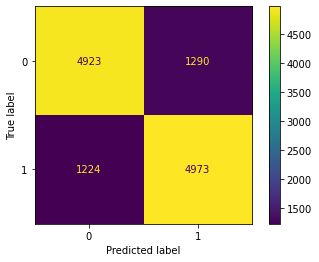

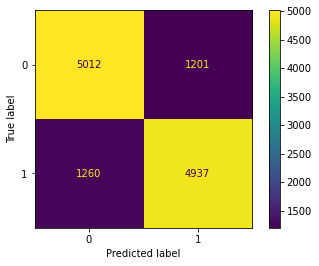

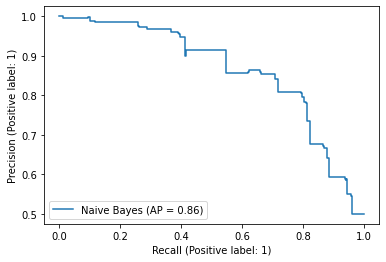

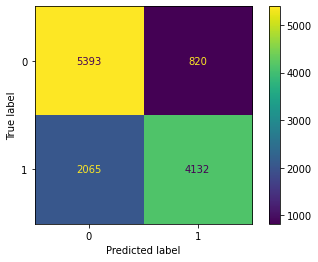

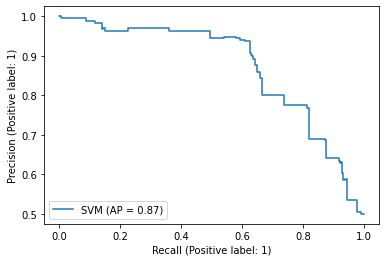

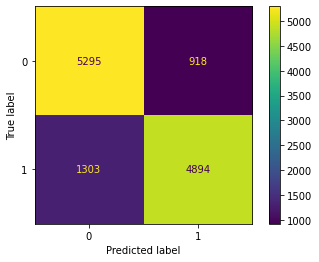

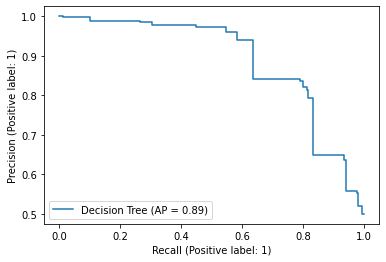

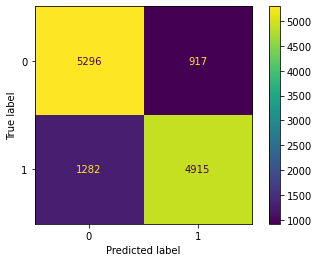

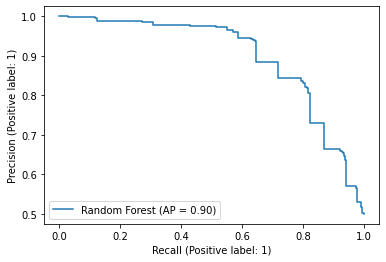

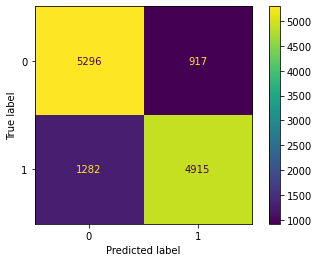

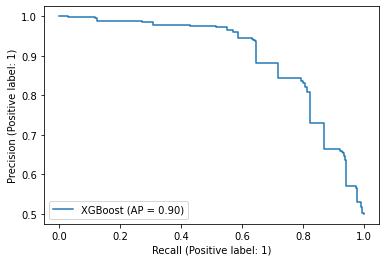

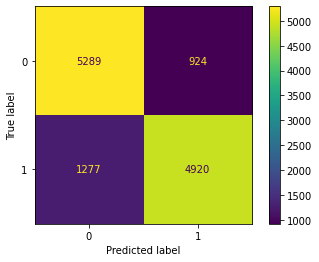

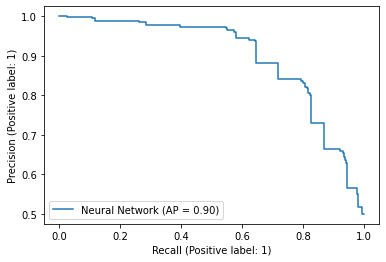

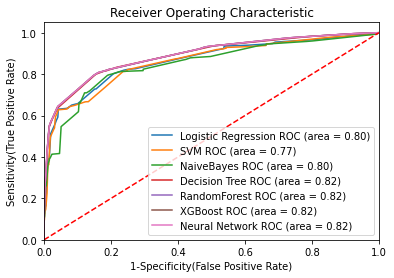

,ML Model,Train Accuracy,Test Accuracy,Kappa Score,time
0,Logistic Regression,0.800081,0.797421,0.594848,0.149965
1,Naive Bayes,0.802639,0.801692,0.603379,0.024187
2,SVM,0.765693,0.767526,0.534931,54.459229
3,Decision Tree,0.821233,0.821031,0.642034,0.025554
4,Random Forest,0.822562,0.822804,0.645581,1.587322
5,XGBoost,0.822562,0.822804,0.645581,0.888390
6,Neural Network,0.822139,0.822643,0.645259,4.444524


In [30]:
def call_ml_models():
    kappa_list = []
    ML_Model = []
    acc_train = []
    acc_test = []
    time_list = []
    model_list = [Logistic_Regression_classifier,Naive_Bayes_classifier,Svm_classifier,Decision_Tree_classifier,Random_Forest_classifier,XG_Boost_classifier,Neural_Network_classifier]
    for model in model_list: 
        res = model()
        ML_Model.append(res[0])
        acc_train.append(res[1])
        acc_test.append(res[2])
        kappa_list.append(res[3]) 
        time_list.append(res[4])
    Roc_curves()
        
    return ML_Model,acc_train,acc_test,kappa_list,time_list  
ML_Model,acc_train,acc_test,kappa_list,time_list = call_ml_models()
results = pd.DataFrame({ 'ML Model': ML_Model, 
    'Train Accuracy': acc_train,
    'Test Accuracy': acc_test, 'Kappa Score': kappa_list, 'time': time_list})
results

## Master function to invoke pre-processing functions

In [31]:
def featureExtraction(url):

    features = []
    #Domain based features (3)
    
    dns = 0
    try:
        domain_name = whois.whois(urlparse(url).netloc)
    except:
        dns = 1

    features.append(rank(url))
    features.append(1 if dns == 1 else isValid(domain_name))
    features.append(1 if dns == 1 else domain_reg_len(domain_name))
    
    
    #Address bar based features (5)
    
    features.append(isRedirect(url))
    features.append(haveDash(url))
    features.append(no_sub_domain(url))
    features.append(LongURL(url))
    features.append(tinyURL(url))
    #features.append(isIP(url))
    #features.append(isat(url)) 
    #features.append(httpDomain(url))
    
  
    return features

## Testing master function

In [32]:
feature_names = ['Rank','isValid','Domain_reg_len','isRedirect','haveDash','SubDomain','LongURL','TinyURL']
data = featureExtraction('www.zvon.org/xxl/WSDL1.1/Output/index.html')
test = pd.DataFrame(np.array(data).reshape((1,-1)))
test.columns=feature_names
#XG_Boost_classifier(test)